In [1]:
import os
import csv
import cv2
import numpy as np
import keras
from scipy import ndimage
from random import shuffle



lines=[]
with open('data/data/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    i_have_seen_firstline=False
    for line in reader:
        if i_have_seen_firstline:
            lines.append(line)
        else:
            i_have_seen_firstline = True
#           
print(len(lines))

#
import sklearn

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)  

print(len(train_samples))
print(len(validation_samples))



def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                #name = './IMG/'+batch_sample[0].split('/')[-1]
                current_path = 'data/data/IMG/' + batch_sample[0].split('/')[-1] 
                current_left_path = 'data/data/IMG/' + batch_sample[1].split('/')[-1] 
                current_right_path = 'data/data/IMG/' + batch_sample[2].split('/')[-1] 
                #center_image = cv2.imread(current_path)
                center_image = ndimage.imread(current_path)
                left_image = ndimage.imread(current_left_path)
                right_image = ndimage.imread(current_right_path)
                center_angle = float(batch_sample[3])
                correction = 0.003  # this is a parameter to tune 0.03 was not bad
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                #left_angle = center_angle *1.15
                #ight_angle = center_angle - 1.15
                use_all_cameras = True
                if use_all_cameras:
                    images.extend([center_image, left_image,right_image])
                    angles.extend([center_angle,left_angle,right_angle])
                else:
                    images.append(center_image)
                    angles.extend(center_angle)
                    
                
            augment_by_flipping=True
            if augment_by_flipping:
                augmented_images, augmented_angles = [],[]
                for image,angle in zip(images, angles):
                    augmented_images.append(image)
                    augmented_angles.append(angle)
                        #augmented_images.append(cv2.flip(image,1))
                    augmented_images.append(np.fliplr(image))
                    augmented_angles.append(angle*-1.0)
            else:
                augmented_images, augmented_angles =images,angles

            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

#images=[]
#measurements=[]
#for line in lines:
#    source_path = line[0]
#    filename= source_path.split('/')[-1]
#    current_path = 'data/data/IMG/' + filename
#    #image=cv2.imread(current_path)
#    image = ndimage.imread(current_path)
#    images.append(image)
#    measurement=float(line[3])
#    measurements.append(measurement)
    
#False
#augment_by_flipping=False
#if augment_by_flipping:
#    augmented_images, augmented_measurements = [],[]
#    for image,measurement in zip(images, measurements):
#        augmented_images.append(image)
#        augmented_measurements.append(measurement)
#        augmented_images.append(cv2.flip(image,1))
#        augmented_measurements.append(measurement*-1.0)
#else:
#    None
#    augmented_images, augmented_measurements =images,measurements
    
    

#X_train = np.array(augmented_images)
#y_train = np.array(augmented_measurements)

/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompa

8036
6428
1608


In [2]:
#print(X_train.shape)
#print(np.mean(y_train**2* 180/3.14*16)) # convert from rad to deg and then to steerin-WEEL-angle 


In [3]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

# compile and train the model using the generator function
my_batch_size= 16 #128
train_generator = generator(train_samples, batch_size=my_batch_size)
validation_generator = generator(validation_samples, batch_size=my_batch_size)

ch, row, col = 3, 160, 320  # Trimmed image format

dropout_prob=1.0#0.8

model=Sequential()
#model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/127.5 - 1.,  #
        input_shape=(row, col,ch))) #,
        #output_shape=(row, col, ch)))

cropping= False
if cropping:
    model.add(Cropping2D(cropping=((50,0), (0,0)), input_shape=(160,320,3)))
#model.add(Flatten())
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
                 #input_shape=(90, 320, 3), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(dropout_prob))

model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(dropout_prob))

model.add(Flatten())

model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(dropout_prob))

model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(dropout_prob))

model.add(Dense(1))

model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 156, 316, 6)       456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 158, 6)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 154, 32)       4832      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 77, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 91168)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               10940280  
__________

In [4]:
###########
print(len(train_samples))
model.compile(loss='mse',optimizer='adam')
#history_object =  model.fit(X_train,y_train,validation_split=0.2,shuffle=True, epochs=4, verbose=1)
#history_object =  model.fit_generator(train_generator, steps_per_epoch= 
#            len(train_samples),validation_steps= 
#            len(train_samples), validation_data=validaright_angle = center_angle - correctiontion_generator,  epochs=2, verbose=1)

history_object =  model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/my_batch_size, 
                    epochs=4,  verbose=1,
            validation_data=validation_generator, validation_steps= len(validation_samples)/my_batch_size, use_multiprocessing=True
            )

6428


/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Epoch 1/4
401/401 [============================>.] - ETA: 0s - loss: 0.5047

/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


402/401 [==============================] - 76s 188ms/step - loss: 0.5035 - val_loss: 0.0120
Epoch 2/4
401/401 [============================>.] - ETA: 0s - loss: 0.0095

/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


402/401 [==============================] - 73s 181ms/step - loss: 0.0095 - val_loss: 0.0105
Epoch 3/4
401/401 [============================>.] - ETA: 0s - loss: 0.0082

/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


402/401 [==============================] - 72s 180ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 4/4
401/401 [============================>.] - ETA: 0s - loss: 0.0073

/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/voll/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


402/401 [==============================] - 70s 175ms/step - loss: 0.0073 - val_loss: 0.0096


dict_keys(['val_loss', 'loss'])


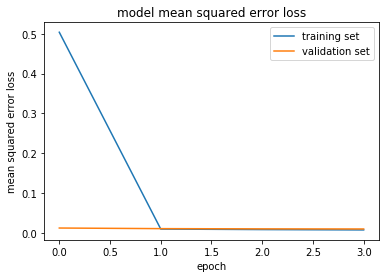

In [5]:
%matplotlib inline  


print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


##############
model.save('model.h5')

In [6]:
keras.__version__

'2.0.9'